In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from iminuit import minimize
from python.analysis import cross_section, Tags, Plots, Master, vector
from apps.cex_analyse import BeamPionSelection
cross_section.SetPlotStyle(extend_colors = True, dpi = 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
args_stopping_muon = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_1GeV_stopping_muon_config.json"))
args_pion = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_1GeV_config.json"))

In [3]:
samples = {"mc" : Master.Data(args_stopping_muon.mc_file, nTuple_type = args_stopping_muon.ntuple_type), "data" : Master.Data(args_stopping_muon.data_file, nTuple_type = args_stopping_muon.ntuple_type)}

In [5]:
stopping_muon_sample = {k : v.Filter(returnCopy = True) for k, v in samples.items()}
pion_sample = {k : v.Filter(returnCopy = True) for k, v in samples.items()}

In [6]:
stopping_muon_sample = {k : BeamPionSelection(v, args_stopping_muon, k == "mc") for k, v in stopping_muon_sample.items()}
pion_sample = {k : BeamPionSelection(v, args_pion, k == "mc") for k, v in pion_sample.items()} 

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to event_index.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply f

In [7]:
def RecoFractionalRange(events : Master.Data, particle : cross_section.Particle, args):
    reco_KE_inst = cross_section.KE(events.recoParticles.beam_inst_P, particle.mass)
    reco_upstream_loss = cross_section.UpstreamEnergyLoss(reco_KE_inst, args.upstream_loss_correction_params["value"])
    reco_KE_ff = reco_KE_inst - reco_upstream_loss
    return events.recoParticles.beam_track_length / cross_section.BetheBloch.RangeFromKE(reco_KE_ff, particle)

muon = cross_section.Particle.from_pdgid(-13)
true_fractional_range = stopping_muon_sample["mc"].trueParticles.beam_track_length / cross_section.BetheBloch.RangeFromKE(stopping_muon_sample["mc"].trueParticles.beam_KE_front_face, muon)

reco_fractional_range = RecoFractionalRange(stopping_muon_sample["mc"], muon, args_stopping_muon)
reco_fractional_range_data = RecoFractionalRange(stopping_muon_sample["data"], muon, args_stopping_muon)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


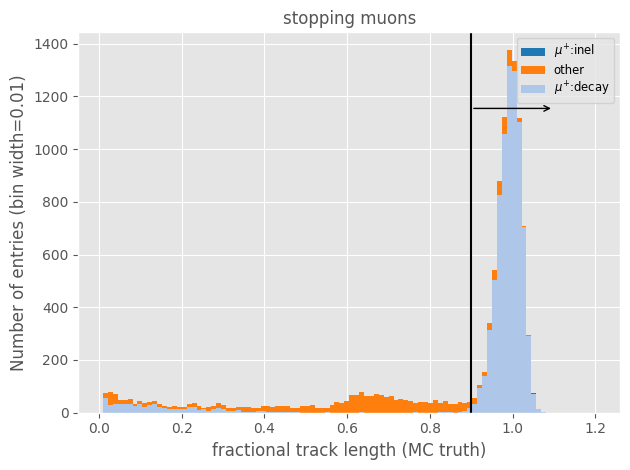

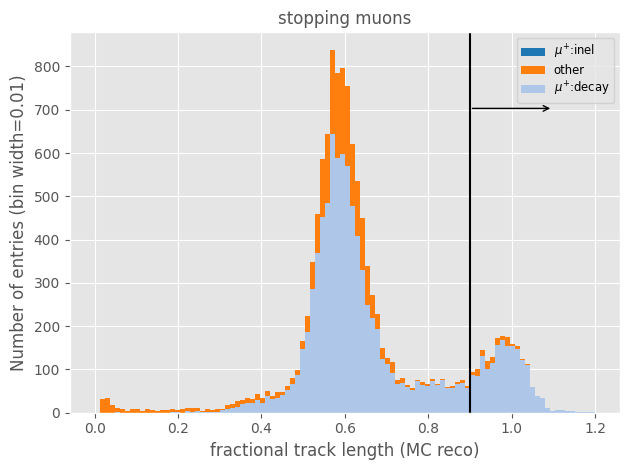

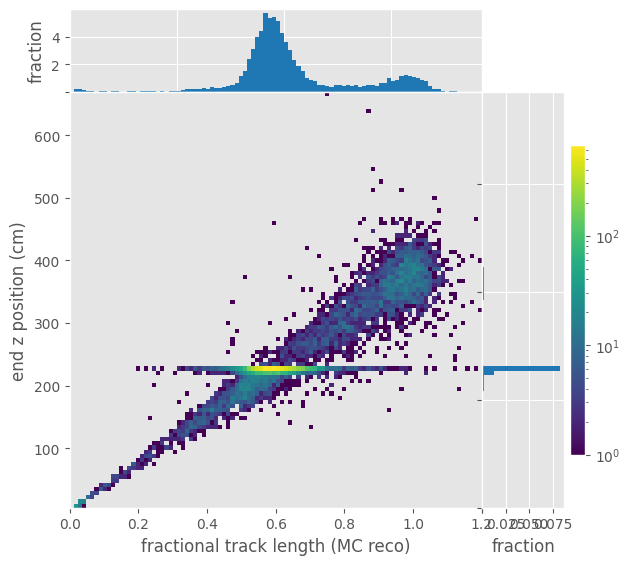

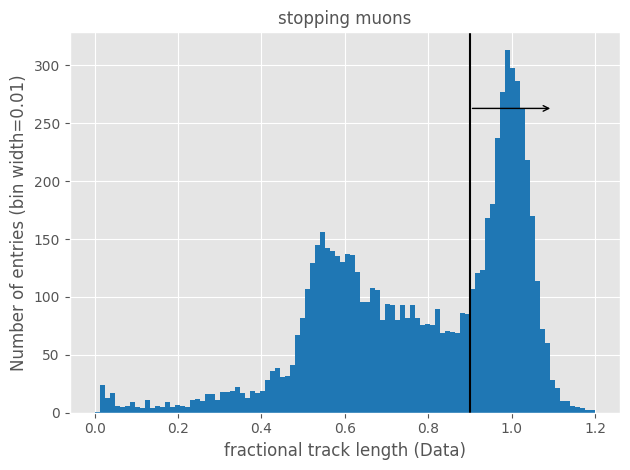

In [11]:
def StoppingMuonTag(events : Master.Data):
    masks = cross_section.Tags.ParticleMasks(events.trueParticlesBT.beam_pdg, [-13])
    masks["other"] = cross_section.Tags.OtherMask(masks)

    decay = events.trueParticlesBT.beam_endProcess == "Decay"

    new_mask = {"$\\mu^{+}$:inel" : masks["$\\mu^{+}$"] & ~decay, "$\\mu^{+}$:decay" : masks["$\\mu^{+}$"] & decay}

    masks.pop("$\\mu^{+}$")

    new_mask.update(masks)
    masks = new_mask

    tags = cross_section.Tags.Tags()
    for i, m in enumerate(masks):
        tags[m] = cross_section.Tags.Tag(m, m, "C" + str(i), masks[m], i)
    return tags

with Plots.PlotBook("stopping_muon_selection.pdf", False) as book:
    Plots.PlotTagged(true_fractional_range, StoppingMuonTag(stopping_muon_sample["mc"]), ncols = 1, x_range = [0.01, 1.2], x_label = "fractional track length (MC truth)", title = "stopping muons")
    Plots.DrawCutPosition(0.9, face = ">")
    book.Save()

    Plots.PlotTagged(reco_fractional_range, StoppingMuonTag(stopping_muon_sample["mc"]), ncols = 1, x_range = [0, 1.2], x_label = "fractional track length (MC reco)", title = "stopping muons")
    Plots.DrawCutPosition(0.9, face = ">")
    book.Save()

    Plots.PlotHist2DMarginal(reco_fractional_range, stopping_muon_sample["mc"].recoParticles.beam_endPos_SCE.z, x_range = [0, 1.2], xlabel = "fractional track length (MC reco)", ylabel = "end z position (cm)")
    book.Save()

    Plots.PlotHist(reco_fractional_range_data, range = [0, 1.2], xlabel = "fractional track length (Data)", title = "stopping muons")
    Plots.DrawCutPosition(0.9, face = ">")
    book.Save()

In [12]:
samples_stopping_muon_selected = {"mc" : stopping_muon_sample["mc"].Filter([reco_fractional_range > 0.9], [reco_fractional_range > 0.9], True), "data" : stopping_muon_sample["data"].Filter([reco_fractional_range_data > 0.9], [reco_fractional_range_data > 0.9], True)}

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


\begin{tabular}{llrrrrrrr}
 & Name & Remaining events & Percentage of total events remaining & Relative percentage events & Remaining PFOs & Percentage of total PFOs remaining & Relative percentage of PFOs & Average PFOs per event \\
0 & Initial data & 298194 & 100.000000 & 100.000000 & 390246 & 100.000000 & 100.000000 & 1.308698 \\
1 & - & 170238 & 57.089680 & 57.089680 & 319663 & 81.913203 & 81.913203 & 1.877742 \\
2 & - & 145004 & 48.627404 & 85.177222 & 308679 & 79.098569 & 96.563881 & 2.128762 \\
3 & - & 142362 & 47.741403 & 98.177981 & 302091 & 77.410403 & 97.865744 & 2.121992 \\
4 & - & 115894 & 38.865302 & 81.407960 & 229484 & 58.804959 & 75.965189 & 1.980120 \\
5 & - & 106545 & 35.730095 & 91.933146 & 208965 & 53.546993 & 91.058636 & 1.961284 \\
6 & - & 101106 & 33.906115 & 94.895115 & 199803 & 51.199244 & 95.615534 & 1.976174 \\
7 & - & 12268 & 4.114100 & 12.133800 & 19651 & 5.035542 & 9.835188 & 1.601810 \\
8 & - & 1868 & 0.626438 & 15.226606 & 2457 & 0.629603 & 12.503180 & 

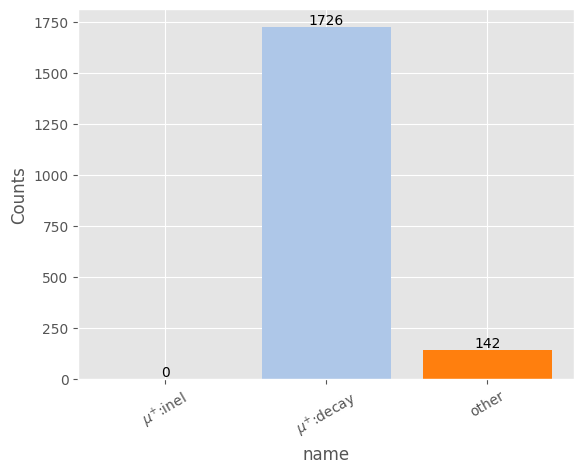

In [13]:
print(samples_stopping_muon_selected["mc"].cutTable.get_table().style.to_latex())
print(samples_stopping_muon_selected["data"].cutTable.get_table().style.to_latex())
Plots.PlotTags(StoppingMuonTag(samples_stopping_muon_selected["mc"]))

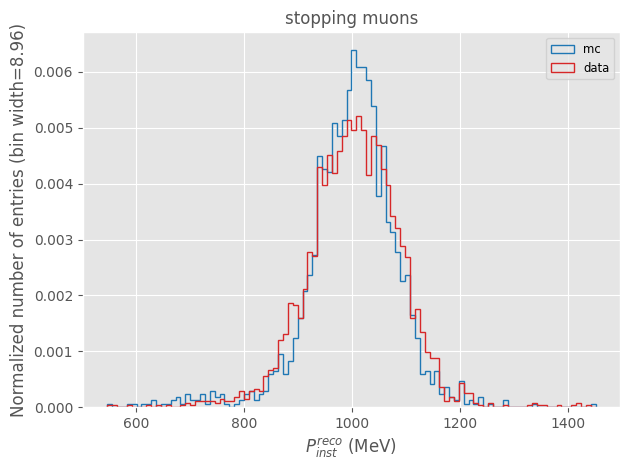

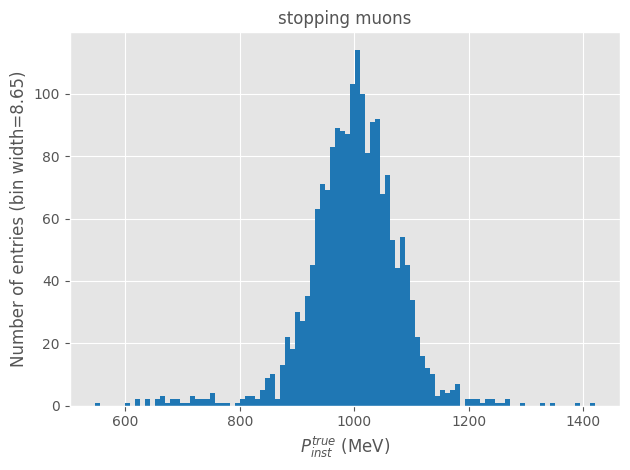

In [14]:
book = Plots.PlotBook("reweight.pdf", False)

Plots.PlotHistComparison([s.recoParticles.beam_inst_P for s in samples_stopping_muon_selected.values()], labels = list(samples_stopping_muon_selected.keys()), xlabel = "$P_{inst}^{reco}$ (MeV)", colours = ["C0", "C6"], title = "stopping muons")
book.Save()

p_inst_true = vector.magnitude(samples_stopping_muon_selected["mc"].trueParticles.momentum[:, 0])

Plots.PlotHist(p_inst_true, xlabel = "$P_{inst}^{true}$ (MeV)", title = "stopping muons")
book.Save()

true_params=array([ 280.02331205, 1002.51848363,   64.2382791 ])
true_params_err=array([8.20613625, 1.5138821 , 1.12224786])


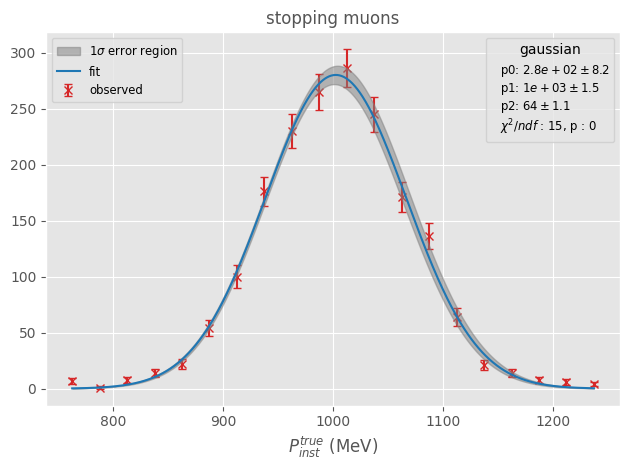

In [20]:
def gauss(x, mu, sigma):
    z = (x - mu) / sigma
    return np.exp(-(z**2)/2)

y, edges = np.histogram(np.array(p_inst_true), 20, range = [750, 1250])
x = (edges[1:] + edges[:-1]) / 2
Plots.plt.figure()
true_params, true_params_err = cross_section.Fitting.Fit(x, y, np.sqrt(y), cross_section.Fitting.gaussian, plot = True, title = "stopping muons", xlabel = "$P_{inst}^{true}$ (MeV)")

print(f"{true_params=}")
print(f"{true_params_err=}")
book.Save()


In [21]:
def Weights(p_inst_true, mu, sigma, mu_0, sigma_0):
    weights = cross_section.Fitting.gaussian(p_inst_true, 1, mu, sigma) / cross_section.Fitting.gaussian(p_inst_true, 1, mu_0, sigma_0)
    return np.where(weights > 3, 3, weights)

weights_stopping_muon = Weights(p_inst_true, true_params[1], true_params[2], true_params[1], true_params[2])
print(weights_stopping_muon)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [22]:
range_to_KE = cross_section.BetheBloch.interp_range_to_KE(2000)

1.6825481798715203


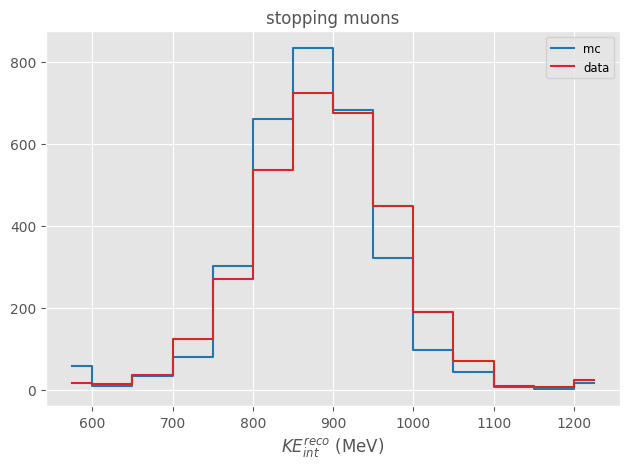

In [23]:
KE_ff_range_bins = np.linspace(550, 1250, 15)

KE_ff_range = {k :range_to_KE(v.recoParticles.beam_track_length) for k, v in samples_stopping_muon_selected.items()}

x = (KE_ff_range_bins[1:] + KE_ff_range_bins[:-1]) / 2
y = {k : np.histogram(np.clip(v, min(KE_ff_range_bins), max(KE_ff_range_bins)), KE_ff_range_bins)[0] for k, v in KE_ff_range.items()}

norm = len(samples_stopping_muon_selected["data"].eventNum)/len(samples_stopping_muon_selected["mc"].eventNum)
print(norm)

Plots.Plot(x, norm * y["mc"], style = "step", color = "C0", label = "mc")
Plots.Plot(x, y["data"], style = "step", color = "C6", label = "data", xlabel = "$KE^{reco}_{int}$ (MeV)", title = "stopping muons", newFigure = False)
book.Save()

In [24]:
def func(p, args):
    mu_fit = p[0]
    sigma_fit = p[1]

    weights = Weights(args["p_inst_true"], mu_fit, sigma_fit, args["mu_0"], args["sigma_0"])
    
    mc = np.clip(args["KE_ff_range"]["mc"], min(args["bins"]), max(args["bins"]))
    data = np.clip(args["KE_ff_range"]["data"], min(args["bins"]), max(args["bins"]))

    hist_mc = np.histogram(mc, args["bins"], weights = weights)[0]
    hist_data = np.histogram(data, args["bins"])[0]
    
    hist_mc = hist_mc * args["norm"]

    bin_index = np.digitize(mc, args["bins"][:-1])

    s = []
    for i in np.linspace(min(bin_index), max(bin_index), len(hist_mc), True):
        w = weights[np.where(bin_index == i)[0]]
        s.append(cross_section.nandiv(sum(w**2), sum(w)))
    s = np.array(s)
    chi2 = (hist_data - hist_mc)**2 / ((s * hist_data) + hist_mc)
    chi2 = np.nansum(chi2) / len(hist_mc)-1
    return chi2

args = {
    "mu_0" : true_params[1],
    "sigma_0" : true_params[2],
    "bins" : KE_ff_range_bins,
    "norm" : norm,
    "p_inst_true" : p_inst_true,
    "KE_ff_range" : KE_ff_range,
    }

result = minimize(func, [true_params[1], true_params[2]], args = [args], method = "simplex")
print(result)

      fun: 3.8290192397658105
 hess_inv: array([[1., 1.],
       [1., 1.]])
  message: 'Optimization terminated successfully, but uncertainties are unrealiable.'
   minuit: <FMin algorithm='Simplex' edm=0.012277293391351307 edm_goal=0.05 errordef=0.5 fval=3.8290192397658105 has_accurate_covar=False has_covariance=False has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=21 ngrad=0 reduced_chi2=nan time=0.32681719999891357>
(Param(number=0, name='x0', value=1013.456606439518, error=0.6560174866298691, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=65.5198296351659, error=2.7453229625762146, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None))
     nfev: 21
     njev: 0
  success: True
        x: array([1013.45660644,   65.51982964])


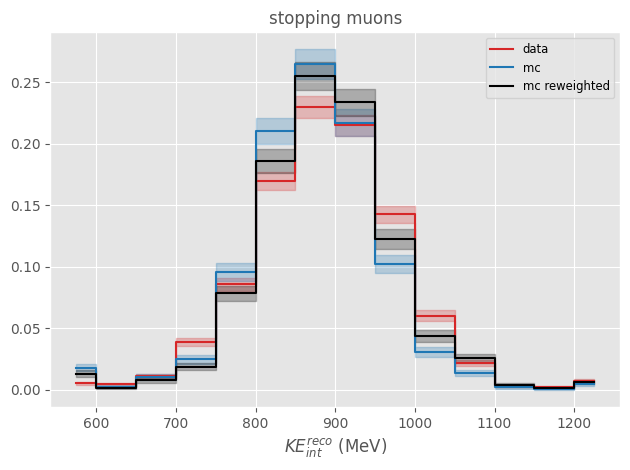

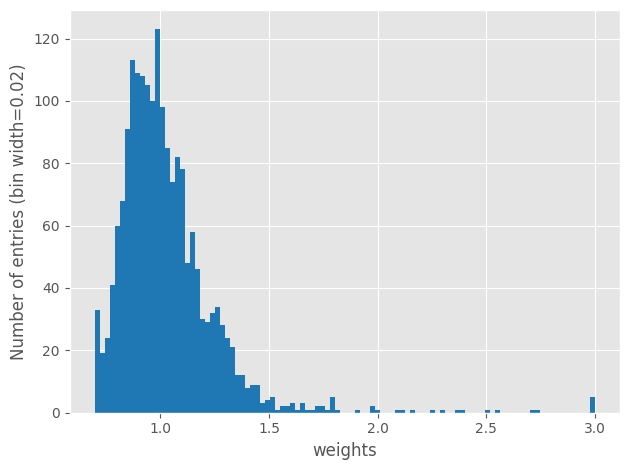

In [36]:
weights_stopping_muon = Weights(args["p_inst_true"], result.x[0], result.x[1], true_params[1], true_params[2])

hist_data = np.histogram(np.clip(args["KE_ff_range"]["data"], min(args["bins"]), max(args["bins"])), args["bins"])[0]

hist_mc = np.histogram(np.clip(args["KE_ff_range"]["mc"], min(args["bins"]), max(args["bins"])), args["bins"])[0]
hist_mc_weighted = np.histogram(np.clip(args["KE_ff_range"]["mc"], min(args["bins"]), max(args["bins"])), args["bins"], weights = weights_stopping_muon)[0]


x = (KE_ff_range_bins[1:] + KE_ff_range_bins[:-1]) / 2
Plots.Plot(x, hist_data / sum(hist_data), yerr = np.sqrt(hist_data) / sum(hist_data), style = "step", label = "data", color = "C6")
Plots.Plot(x, hist_mc / sum(hist_mc), yerr = np.sqrt(hist_mc) / sum(hist_mc), style = "step", label = "mc", color = "C0", newFigure = False)
Plots.Plot(x, hist_mc_weighted / sum(hist_mc_weighted), yerr = np.sqrt(hist_mc_weighted) / sum(hist_mc_weighted), style = "step", label = "mc reweighted", color = "k", xlabel = "$KE^{reco}_{int}$ (MeV)", title = "stopping muons", newFigure = False)
book.Save()
Plots.PlotHist(weights_stopping_muon, xlabel = "weights")
book.Save()

fit_results_mc=(array([ 176.43560841, 1015.02199939,   68.97830638]), array([5.23590351, 1.61711638, 1.26716247]))
fit_results_data=(array([ 268.75631108, 1003.71517133,   75.64129965]), array([6.01877233, 1.37929001, 1.00940737]))
smearing_mu, smearing_mu_err=(-11.30682806492905, 2.1254426158698623)
smearing_sigma, smearing_sigma_err=(31.041898479871794, 3.7387864082140636)


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


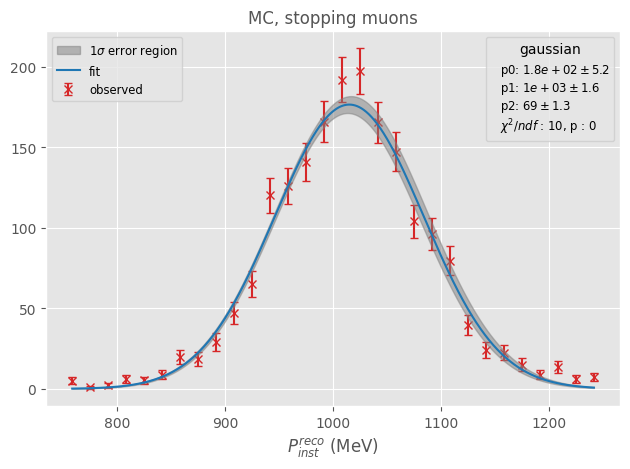

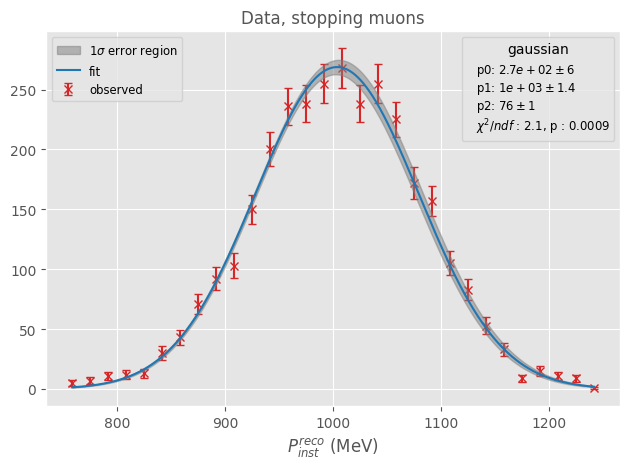

In [26]:
y, edges = np.histogram(np.array(samples_stopping_muon_selected["mc"].recoParticles.beam_inst_P), 30, range = [750, 1250], weights = np.array(weights_stopping_muon))
x = (edges[1:] + edges[:-1]) / 2
Plots.plt.figure()
fit_results_mc = cross_section.Fitting.Fit(x, y, np.sqrt(y), cross_section.Fitting.gaussian, plot = True, xlabel = "$P_{inst}^{reco}$ (MeV)", title = "MC, stopping muons")
book.Save()

y, edges = np.histogram(np.array(samples_stopping_muon_selected["data"].recoParticles.beam_inst_P), 30, range = [750, 1250])
x = (edges[1:] + edges[:-1]) / 2
Plots.plt.figure()
fit_results_data = cross_section.Fitting.Fit(x, y, np.sqrt(y), cross_section.Fitting.gaussian, plot = True, xlabel = "$P_{inst}^{reco}$ (MeV)", title = "Data, stopping muons")
book.Save()

smearing_mu = fit_results_data[0][1] - fit_results_mc[0][1]
smearing_sigma = np.sqrt(fit_results_data[0][2]**2 - fit_results_mc[0][2]**2)

smearing_mu_err = np.sqrt(fit_results_data[1][1]**2 + fit_results_mc[1][1]**2)

smearing_sigma_err = (1/smearing_sigma) * np.sqrt((fit_results_data[0][2] * fit_results_data[1][2])**2 + (fit_results_mc[0][2] * fit_results_mc[1][2])**2)

print(f"{fit_results_mc=}")
print(f"{fit_results_data=}")

print(f"{smearing_mu, smearing_mu_err=}")
print(f"{smearing_sigma, smearing_sigma_err=}")

book.close()

In [69]:
smearing_mc_pions = -np.random.normal(smearing_mu, smearing_sigma, len(pion_sample["mc"].eventNum))

In [79]:
def KEs(samples, upstream_energy_loss_params, smearing : np.array = None):
    KE_samples = {}

    if smearing is None:
        smearing = np.zeros(len(samples["mc"].eventNum))

    for s in samples:
        obs = {}
        p = samples[s].recoParticles.beam_inst_P + smearing if s == "mc" else samples[s].recoParticles.beam_inst_P
        obs["reco_KE_inst"] = cross_section.KE(p, cross_section.Particle.from_pdgid(211).mass)

        reco_upstream_loss = cross_section.UpstreamEnergyLoss(obs["reco_KE_inst"], upstream_energy_loss_params)
        obs["reco_KE_ff"] = obs["reco_KE_inst"] - reco_upstream_loss
        obs["reco_KE_int"] = obs["reco_KE_ff"] - cross_section.RecoDepositedEnergy(samples[s], obs["reco_KE_ff"], "bb")
        # reco_track_length = samples[s].recoParticles.beam_track_length
        # outside_tpc_reco = (samples[s].recoParticles.beam_endPos_SCE.z < 0) | (samples[s].recoParticles.beam_endPos_SCE.z > 700)
        KE_samples[s] = obs
    return KE_samples


def MakePlots(pion_sample : dict[Master.Data], reco_KEs : dict[dict[np.array]], tags : cross_section.Tags, weights : np.array = None, smearing : np.array = None, book : Plots.PlotBook = Plots.PlotBook.null):
    if smearing is None:
        smearing = np.zeros(len(pion_sample["mc"].eventNum))
    Plots.PlotTagged(pion_sample["mc"].recoParticles.beam_inst_P + smearing, tags(pion_sample["mc"]), data2 = pion_sample["data"].recoParticles.beam_inst_P, bins = 50, x_range = [750, 1250], norm = True, loc = "upper left", x_label = "$P_{inst}^{reco}$(MeV)", data_weights = weights)
    book.Save()
    Plots.PlotTagged(reco_KEs["mc"]["reco_KE_inst"], tags(pion_sample["mc"]), data2 = reco_KEs["data"]["reco_KE_inst"], bins = 50, x_range = [550, 1100], norm = True, loc = "upper left", x_label = "$KE_{inst}^{reco}$(MeV)", data_weights = weights)
    book.Save()
    Plots.PlotTagged(reco_KEs["mc"]["reco_KE_ff"], tags(pion_sample["mc"]), data2 = reco_KEs["data"]["reco_KE_ff"], bins = 50, x_range = [550, 1100], norm = True, loc = "upper left", x_label = "$KE_{init}^{reco}$(MeV)", data_weights = weights)
    book.Save()    
    Plots.PlotTagged(reco_KEs["mc"]["reco_KE_int"], tags(pion_sample["mc"]), data2 = reco_KEs["data"]["reco_KE_int"], bins = 50, x_range = [0, 1100], norm = True, loc = "upper left", x_label = "$KE_{int}^{reco}$(MeV)", data_weights = weights)
    book.Save()
    return


In [81]:
smearing_stopping_muon = -np.random.normal(smearing_mu, smearing_sigma, len(stopping_muon_sample["mc"].eventNum))

weights_stopping_muon = Weights(vector.magnitude(pion_sample["mc"].trueParticles.momentum[:, 0]), result.x[0], result.x[1], true_params[1], true_params[2])
reco_KE_smeared_sm = KEs(stopping_muon_sample, args_stopping_muon.upstream_loss_correction_params["value"], smearing_stopping_muon)
reco_KE_unsmeared_sm = KEs(stopping_muon_sample, args_stopping_muon.upstream_loss_correction_params["value"])

track_length/n=<Array [6.37, 4.67, 7.88, ... 4.73, 4.66, 3.96] type='12268 * float64'>


'InteractingKE' executed in 0.1749s

'RecoDepositedEnergy' executed in 2.1068s

track_length/n=<Array [7.63, 8.14, 4.36, ... 6.8, 5.88, 5.53] type='7236 * float64'>


'InteractingKE' executed in 0.1475s

'RecoDepositedEnergy' executed in 0.8600s

track_length/n=<Array [6.37, 4.67, 7.88, ... 4.73, 4.66, 3.96] type='12268 * float64'>


'InteractingKE' executed in 0.1687s

'RecoDepositedEnergy' executed in 2.1638s

track_length/n=<Array [7.63, 8.14, 4.36, ... 6.8, 5.88, 5.53] type='7236 * float64'>


'InteractingKE' executed in 0.1552s

'RecoDepositedEnergy' executed in 0.9899s

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1282: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1283: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((data_err/h_data)**2 + (mc_error/h_mc)**2)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


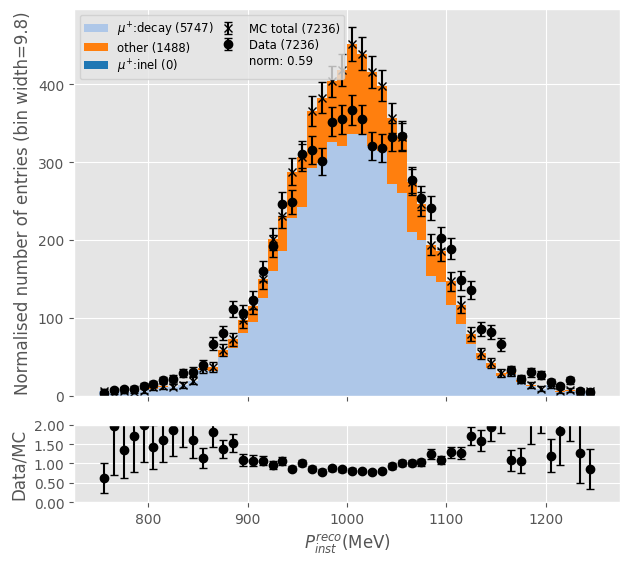

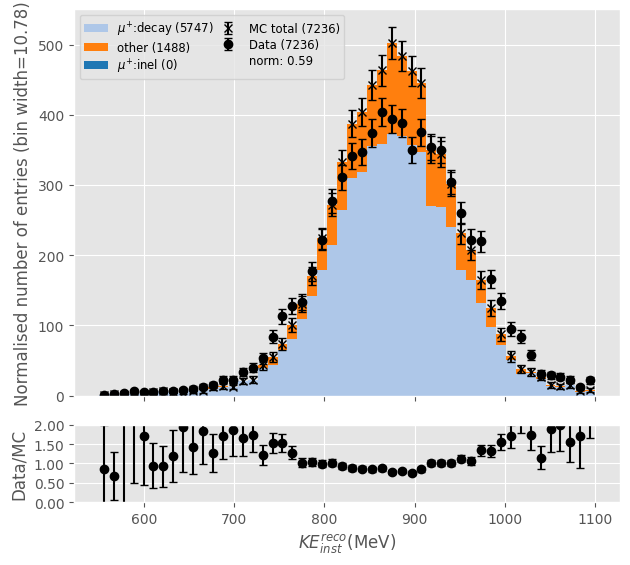

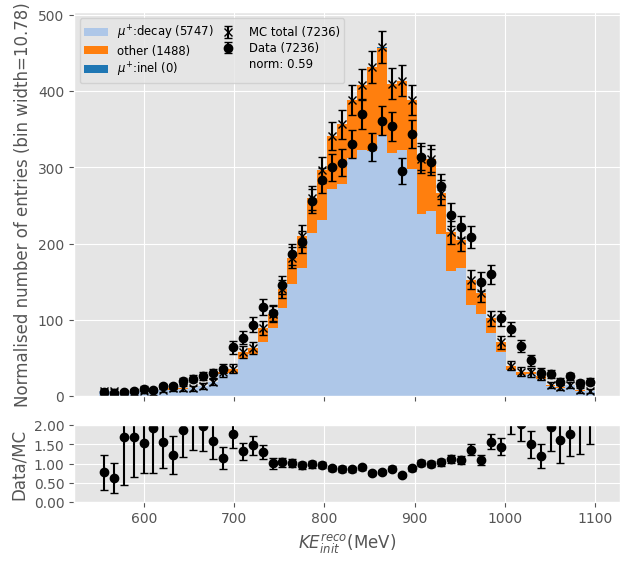

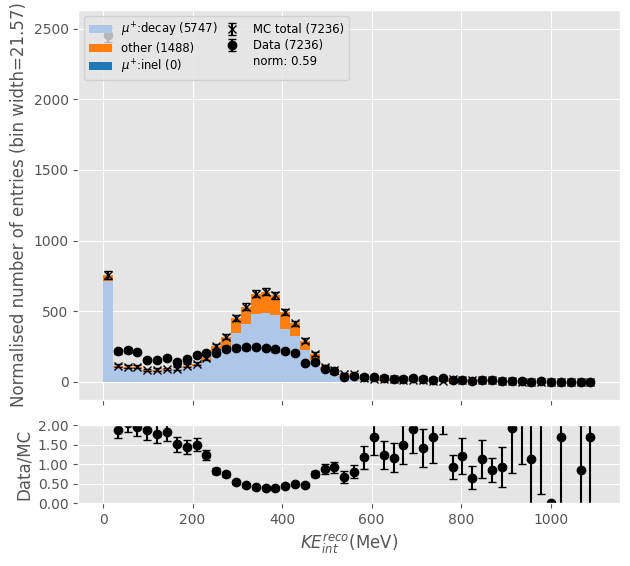

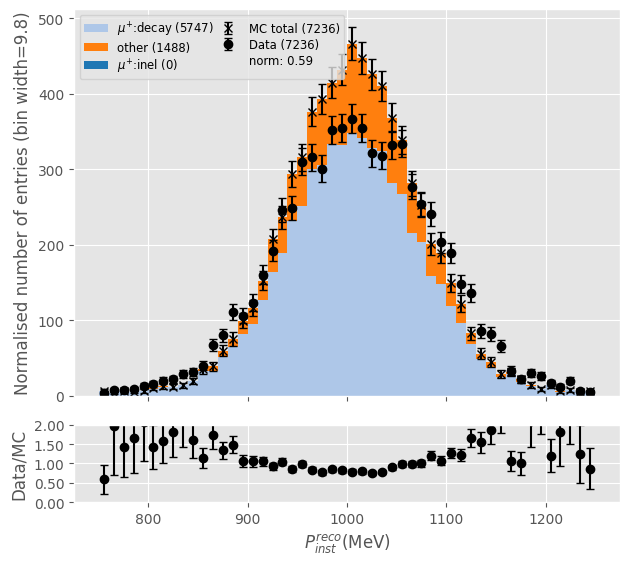

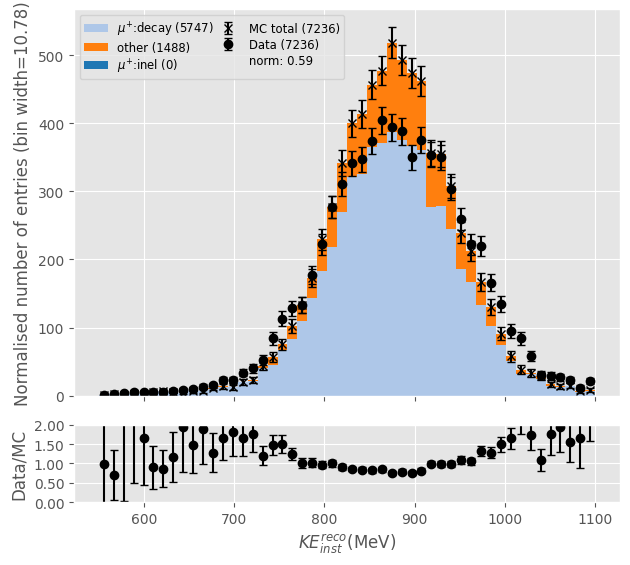

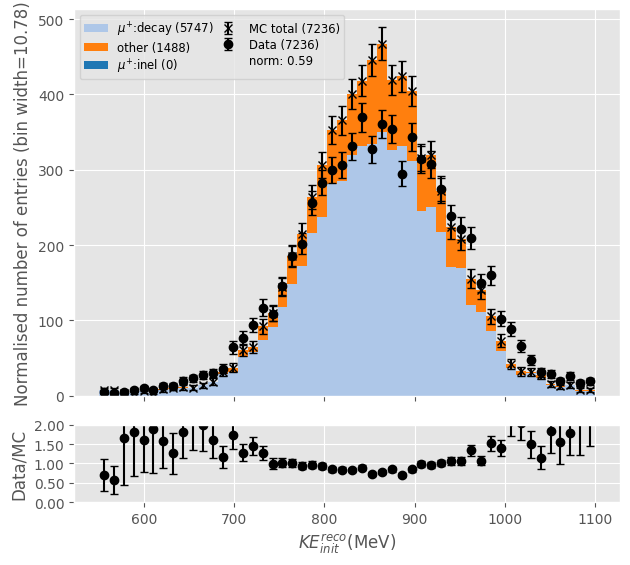

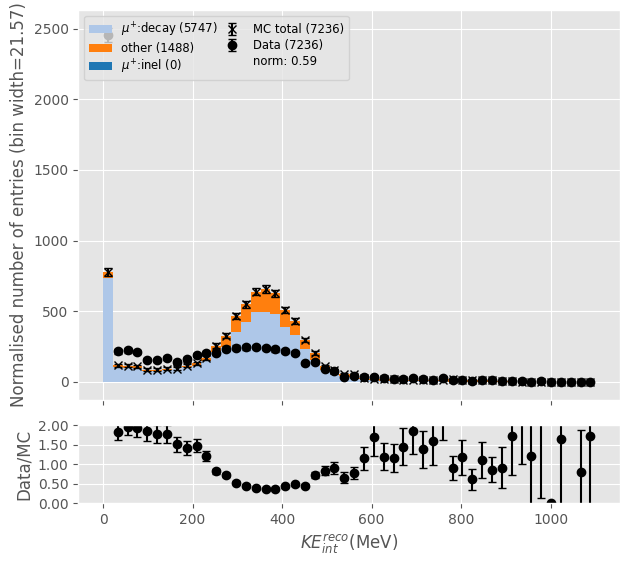

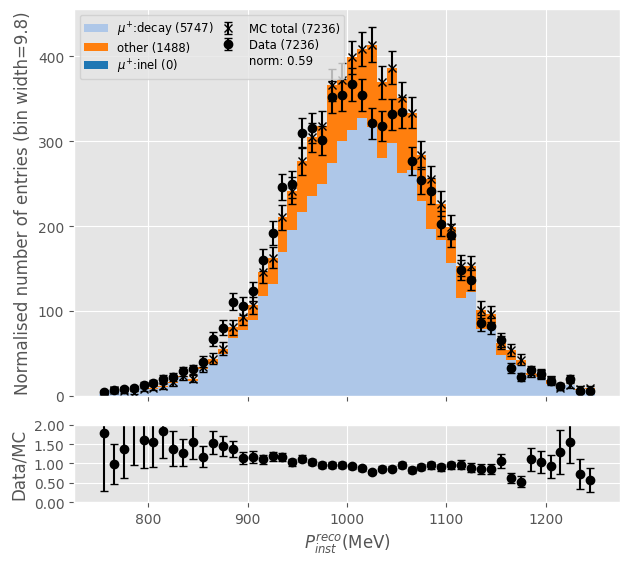

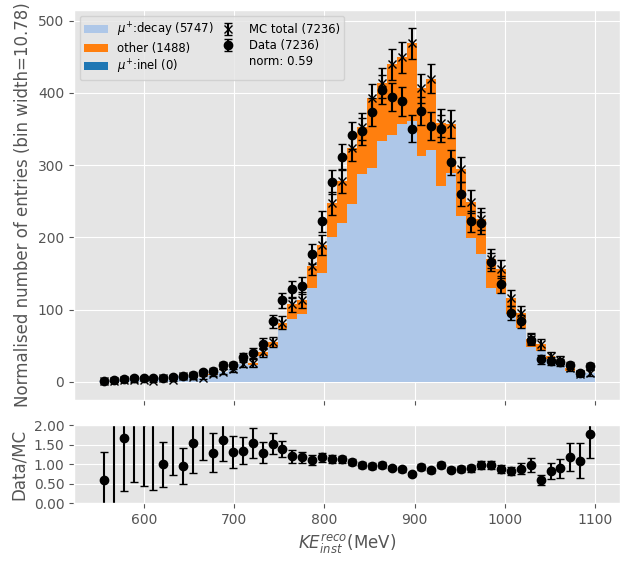

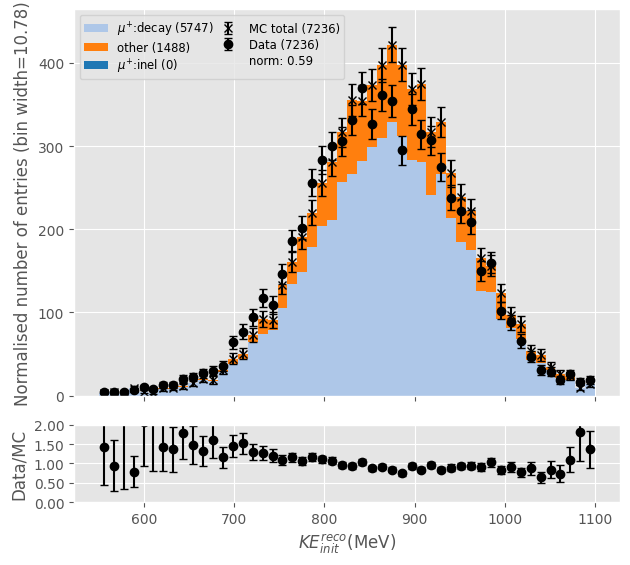

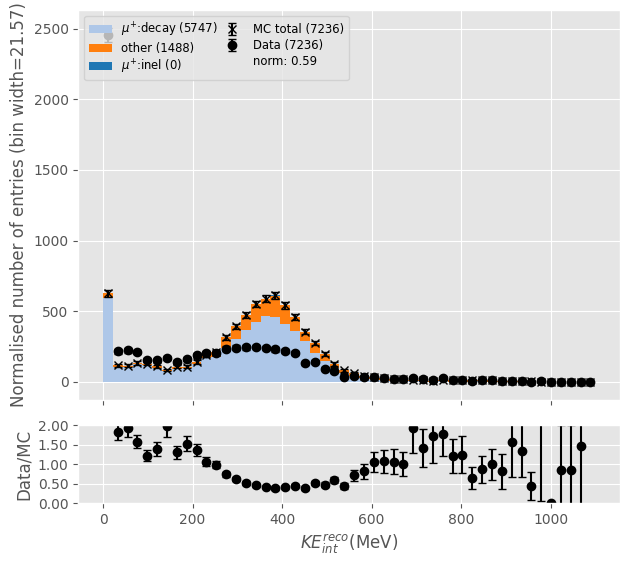

In [82]:
with Plots.PlotBook("stopping_muon_nominal.pdf", False) as book:
    MakePlots(stopping_muon_sample, reco_KE_unsmeared_sm, StoppingMuonTag, None, None, book)

with Plots.PlotBook("stopping_muon_reweight.pdf", False) as book:
    MakePlots(stopping_muon_sample, reco_KE_unsmeared_sm, StoppingMuonTag, weights_stopping_muon, None, book)

with Plots.PlotBook("stopping_muon_reweight_smeared.pdf", False) as book:
    MakePlots(stopping_muon_sample, reco_KE_smeared_sm, StoppingMuonTag, weights_stopping_muon, smearing_stopping_muon, book)

In [83]:
weights_pion_sample = Weights(vector.magnitude(pion_sample["mc"].trueParticles.momentum[:, 0]), result.x[0], result.x[1], true_params[1], true_params[2])
reco_KE_unsmeared = KEs(pion_sample, args_pion.upstream_loss_correction_params["value"])
reco_KE_smeared = KEs(pion_sample, args_pion.upstream_loss_correction_params["value"], smearing_mc_pions)


track_length/n=<Array [0.237, 1.77, 0.673, ... 1.22, 0.988] type='45581 * float64'>


'InteractingKE' executed in 0.2916s

'RecoDepositedEnergy' executed in 2.3501s

track_length/n=<Array [1, 0.478, 3.23, ... 2.81, 0.335, 2.04] type='29810 * float64'>


'InteractingKE' executed in 0.3579s

'RecoDepositedEnergy' executed in 1.1950s

track_length/n=<Array [0.237, 1.77, 0.673, ... 1.22, 0.988] type='45581 * float64'>


'InteractingKE' executed in 0.3654s

'RecoDepositedEnergy' executed in 2.9913s

track_length/n=<Array [1, 0.478, 3.23, ... 2.81, 0.335, 2.04] type='29810 * float64'>


'InteractingKE' executed in 0.3445s

'RecoDepositedEnergy' executed in 1.2743s

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1282: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC


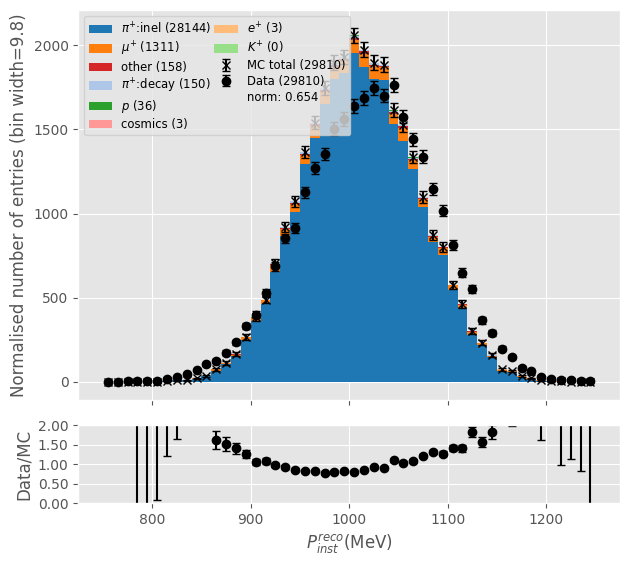

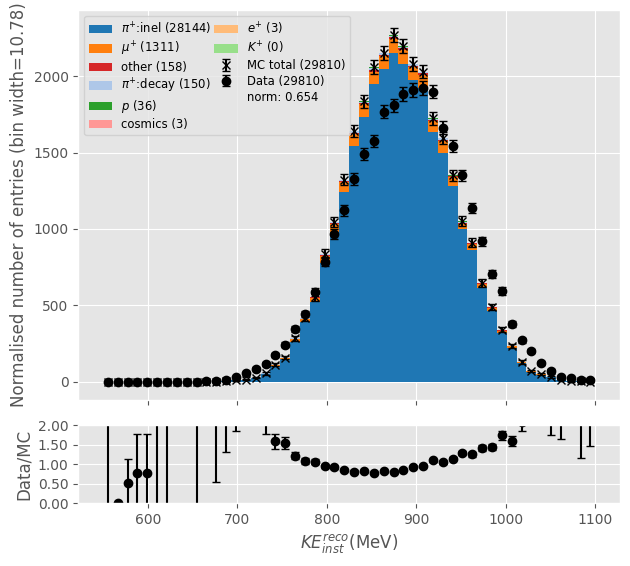

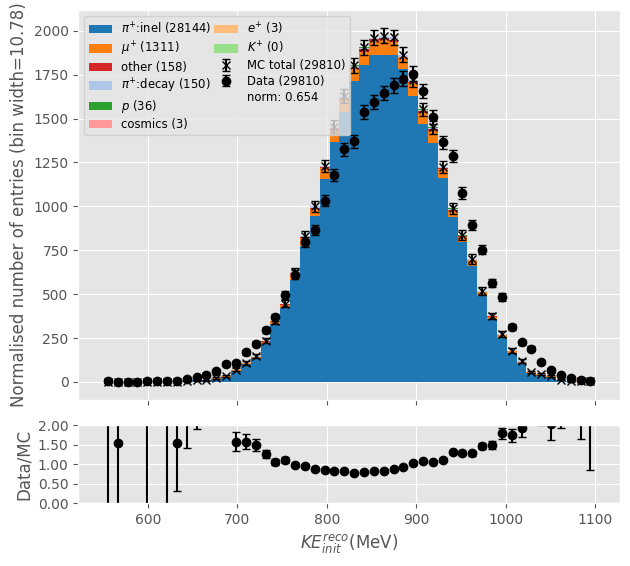

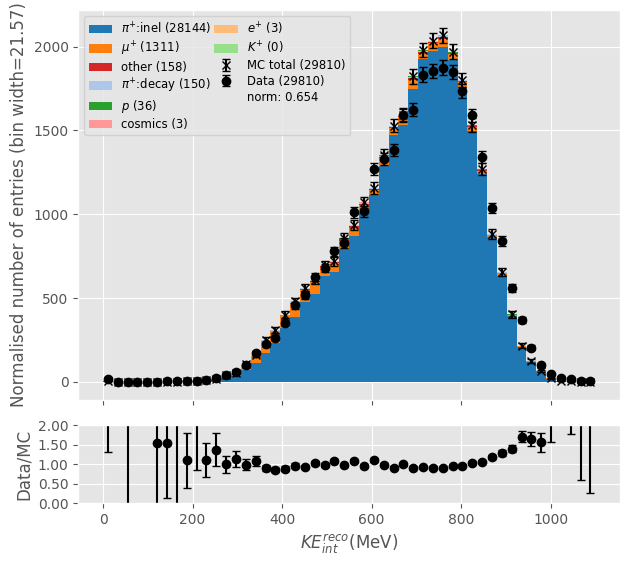

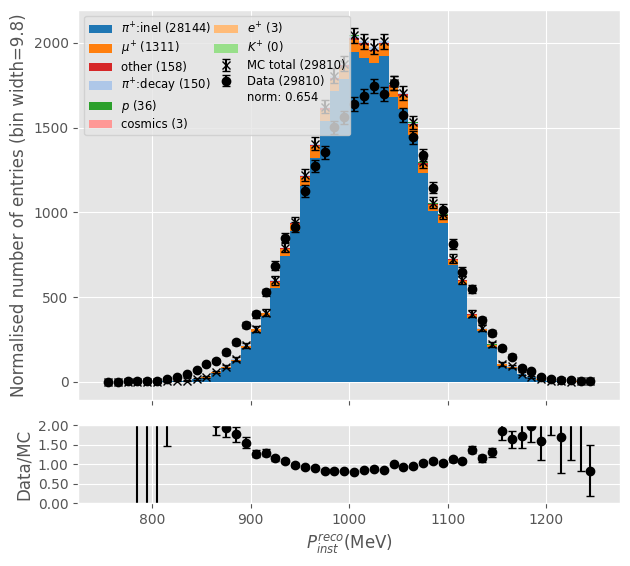

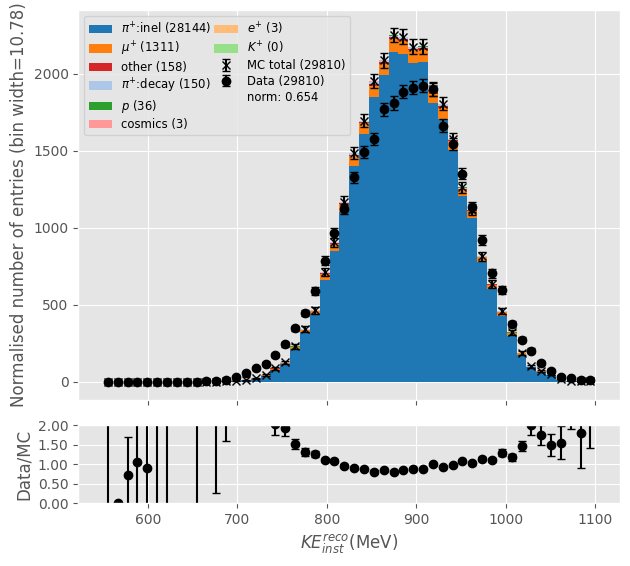

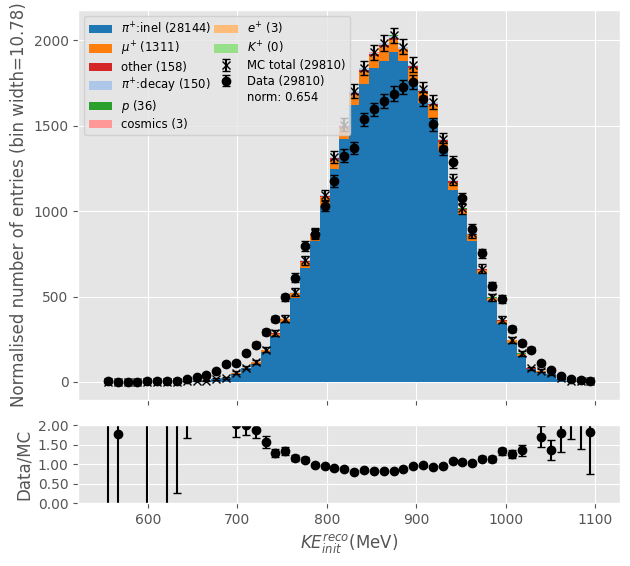

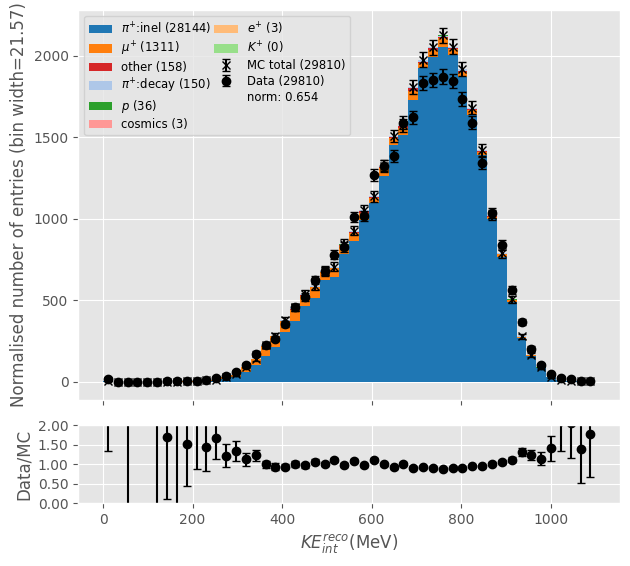

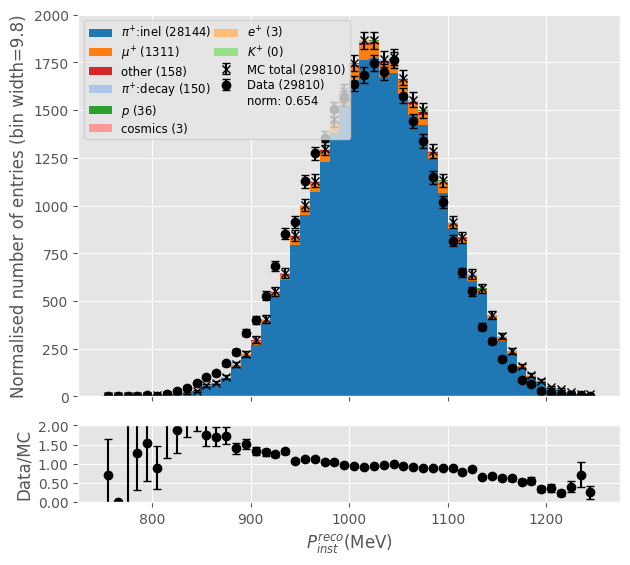

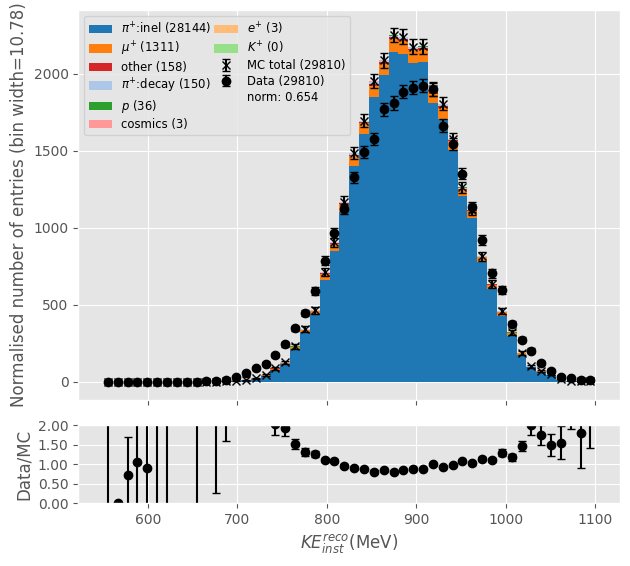

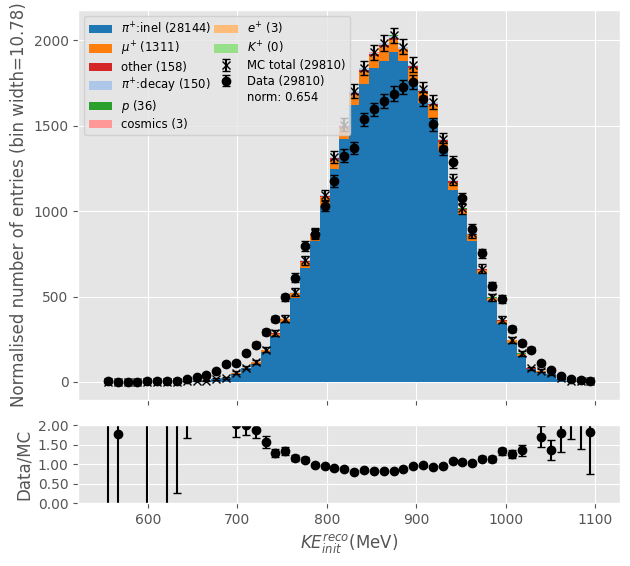

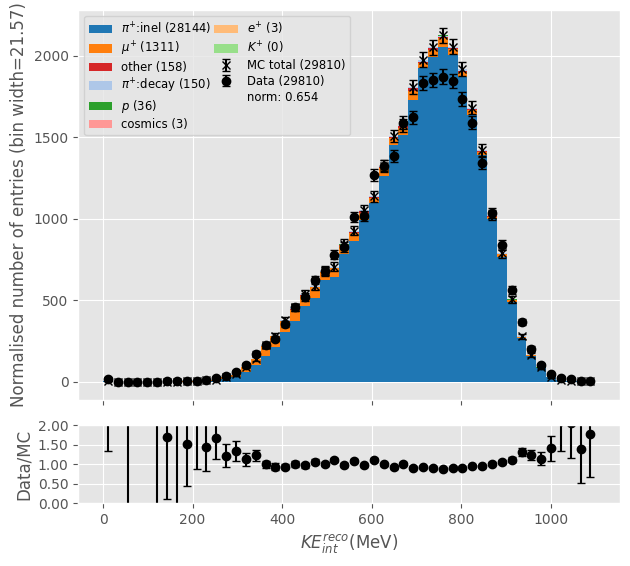

In [84]:
with Plots.PlotBook("pion_nominal.pdf", False) as book:
    MakePlots(pion_sample, reco_KE_unsmeared, cross_section.Tags.GenerateTrueBeamParticleTags, None, None, book)

with Plots.PlotBook("pion_reweight.pdf", False) as book:
    MakePlots(pion_sample, reco_KE_unsmeared, cross_section.Tags.GenerateTrueBeamParticleTags, weights_pion_sample, None, book)

with Plots.PlotBook("pion_reweight_smeared.pdf", False) as book:
    MakePlots(pion_sample, reco_KE_unsmeared, cross_section.Tags.GenerateTrueBeamParticleTags, weights_pion_sample, smearing_mc_pions, book)
